In [27]:
import os
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
from dataset import AudioDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Exploring the data

Plotting several random waveforms from each folder will help us understand, whether the commands are noisy and time-alligned and give hints about decisions we'll have to make further down the way.

In [11]:
root_dir = '/home/apelykh/datasets/speech_commands_v0.02'

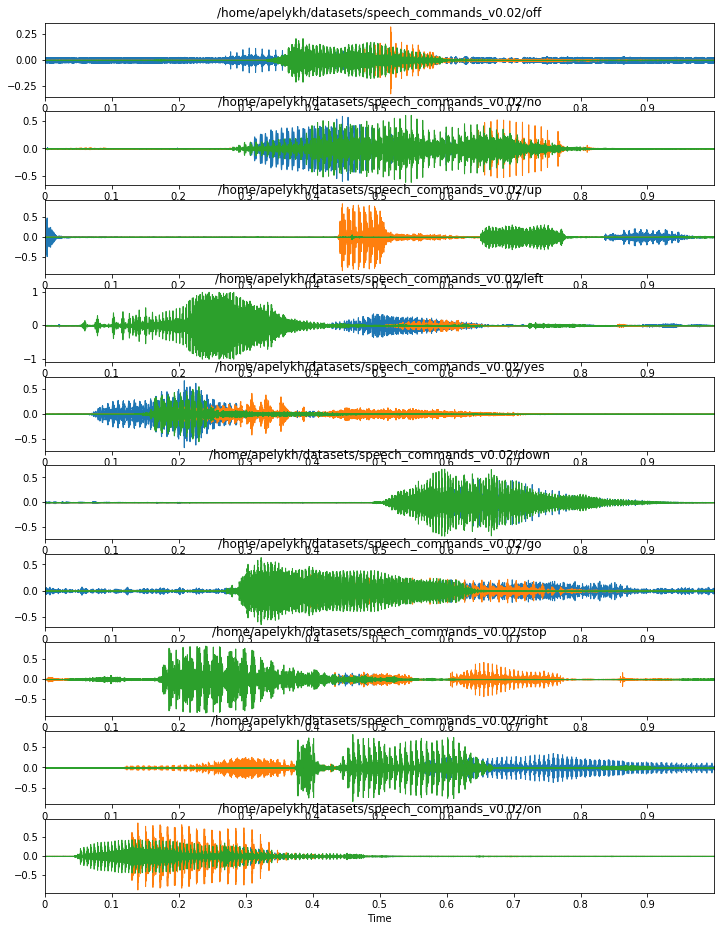

In [8]:
wavs_to_print = 3
plt.figure(figsize=(12, 16))

dir_i = 1
for entry in os.listdir(root_dir):
    dirpath = os.path.join(root_dir, entry)
    if os.path.isdir(dirpath):
        plt.subplot(10, 1, dir_i)
        plt.title(dirpath)
        listdir = list(os.listdir(dirpath))

        # print 3 random waveforms for each folder
        for wavefile in random.choices(listdir, k=wavs_to_print):
            if wavefile[-4:] == '.wav':
                full_path = os.path.join(dirpath, wavefile)
                x, sr = librosa.load(full_path)
                librosa.display.waveplot(x)
        dir_i += 1

We can notice several things from these plots:
1. Audio files are not normalized by amplitude;
2. Some of them have substantial amount of noise;
3. Files are not time aligned and the meaningful data can be located in different parts of the file;

---
### Visualizing computed features and normalized waveforms

In [13]:
d = AudioDataset(root_dir, mode='val', seed=123)

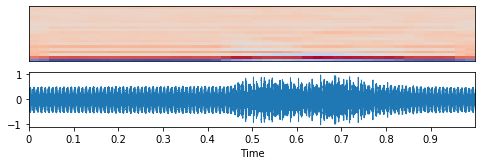

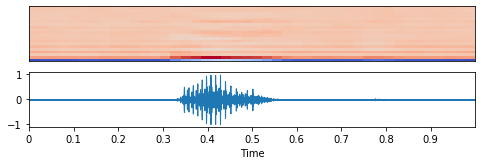

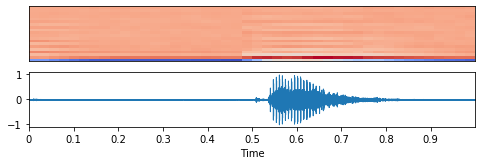

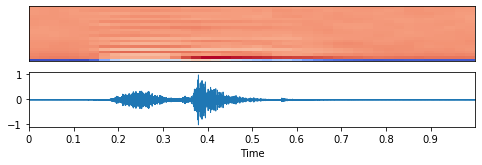

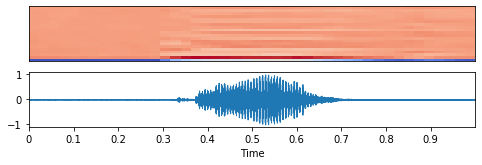

In [15]:
for i in range(len(d)):
    sample = d[i]
    if i < 5:
        plt.figure(figsize=(8, 24))
        plt.subplot(20, 1, i + 1)
        librosa.display.specshow(sample['mfcc'])
        plt.subplot(20, 1, i + 2)
        librosa.display.waveplot(sample['audio'])
    else:
        break

---

### Visualizing the feature space

Now let's try to visualize the high-dimensional feature space with the help of t-SNE and UMAP to get a grasp of its structure

In [17]:
# limit the number of samples for each class to 200 to read the data faster
# and make the job easier for t-SNE and UMAP
d = AudioDataset(root_dir,
                 mode='train',
                 train_val_test_split=(1.0, 0.0, 0.0),
                 limit_num_samples=300,
                 seed=123)
print(len(d))

3000


In [20]:
# populate the matrix with mfcc values for the reduced dataset
# to fit t-SNE and UMAP on it
flat_mfcc_len = d[0]['mfcc'].shape[0] * d[0]['mfcc'].shape[1]
flat_mfcc = np.zeros((len(d), flat_mfcc_len))
labels = np.zeros(len(d), dtype=np.int)

for i, sample in enumerate(d):
    if i % 500 == 0:
        print(i)
    flat_mfcc[i] = sample['mfcc'].flatten()
    labels[i] = sample['label']

0
500
1000
1500
2000
2500


In [21]:
print(flat_mfcc.shape)

(3000, 880)


### t-SNE

In [28]:
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(flat_mfcc)

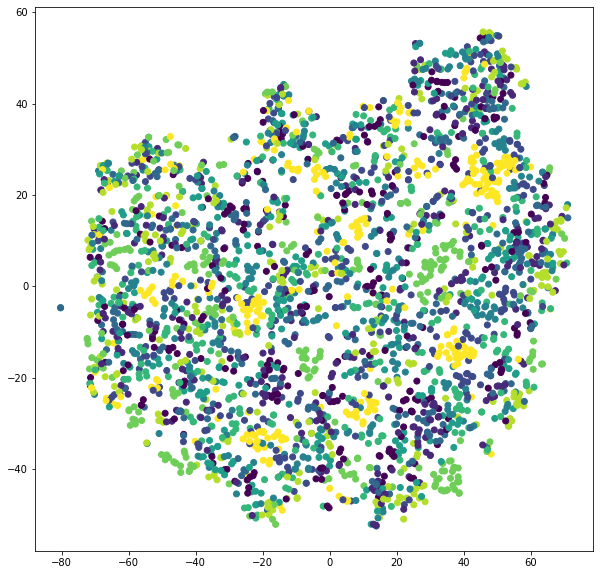

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(transformed_data[:, 0],
            transformed_data[:, 1],
            c=labels)
plt.show()

### UMAP
paper: https://arxiv.org/pdf/1802.03426.pdf

In [25]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(flat_mfcc)
embedding.shape

(3000, 2)

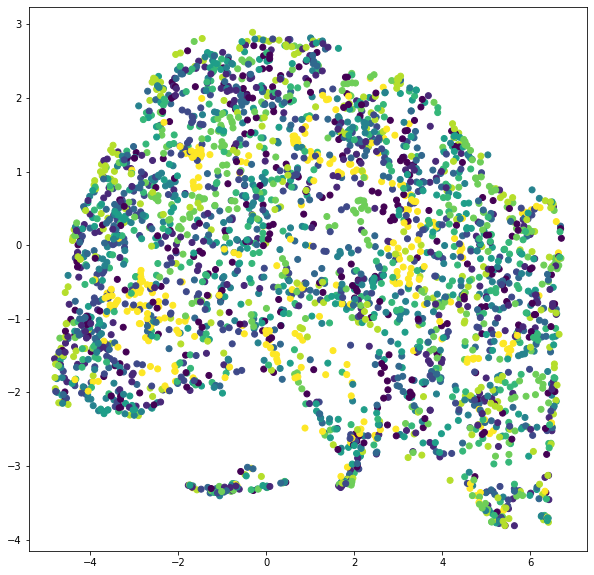

In [26]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0],
            embedding[:, 1],
            c=labels)
plt.show()

Unfortunately, neither t-SNE, nor UMAP doesn't show any obvious clusters in the MFCC feature space. Let's hope that samples will be better separable in the convolutional feature space, learned by the model in supervised setting. 